In [1]:
!pip install kaggle
from google.colab import files 
files.upload() #download and upload json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samratalam","key":"cad80de460ce88e637f7223e78a7ab03"}'}

In [2]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c digit-recognizer

 82% 5.00M/6.09M [00:00<00:00, 47.9MB/s]
100% 6.09M/6.09M [00:00<00:00, 38.9MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.1MB/s]
 55% 5.00M/9.16M [00:00<00:00, 31.5MB/s]
100% 9.16M/9.16M [00:00<00:00, 44.7MB/s]


In [4]:
#to unzip file

from zipfile import ZipFile
file_name= "train.csv.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
#to unzip file

from zipfile import ZipFile
file_name= "test.csv.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
#import library

#ignore warnig
import warnings
warnings.warn('ignore')        ########################

#handel tabel like data and metrices
import numpy as np
import pandas as pd
import math
import itertools

#visualization
import matplotlib.pyplot as plt

#modeling helper
from sklearn.model_selection import train_test_split

#deep learnig libraries
from keras.models import Sequential , load_model
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Flatten,Dropout
from keras.optimizers import Adam

#preprocessing
from keras.preprocessing.image import ImageDataGenerator


from keras.utils import to_categorical

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: ignore
  """


In [7]:
#loading data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train_df = train.copy()
test_df = test.copy()

In [8]:
#havig a look at the data
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.00000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,...,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00300,0.011190,0.005143,0.000214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.001310,0.010548,0.027262,0.050905,0.066405,0.129571,...,3.772524,2.748905,1.796452,1.089905,0.563190,0.239571,0.093524,0.024833,0.000857,0.001405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006143,0.035833,0.082357,0.114905,0.178714,0.301452,0.413643,0.513667,0.558833,0.677857,0.60281,0.489238,0.340214,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.56812,1.626927,1.053972,0.043916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078072,0.232634,1.131661,2.310396,3.121847,3.259128,4.992894,...,26.957829,22.879248,18.595109,14.434439,10.517823,6.469315,3.976306,1.846016,0.139556,0.287891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.949803,2.350859,3.934280,4.543583,5.856772,7.219742,8.928286,10.004069,10.129595,11.254931,10.69603,9.480066,7.950251,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [9]:
#We can see there is one column that has the label and the rest are the image pixels!

In [10]:
test_df.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001357,0.012500,0.016786,0.031714,0.056000,0.100464,0.166929,...,3.272536,2.371464,1.454357,0.846286,0.509750,0.254750,0.062107,0.015250,0.000786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005429,0.024179,0.036250,0.083143,0.134107,0.201071,0.325000,0.366714,0.468143,0.589429,0.656964,0.569714,0.464214,0.323679,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227093,1.566275,1.513515,2.674449,3.216234,4.549478,5.470524,...,25.211706,21.240003,16.643468,12.637953,9.963879,7.031504,3.040514,1.265562,0.131475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640468,2.234963,2.493982,3.777711,4.946940,6.262819,7.714814,8.243535,8.974038,10.488695,11.209508,10.204173,9.402197,7.878854,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [11]:
#In test there is no label 

In [12]:
print(train_df.shape)

(42000, 785)


In [13]:
#check null value
train_df.isnull().any().sum()

0

In [14]:

test_df.isnull().any().sum()

0

In [15]:
#setting seed value
seed=22
np.random.seed(seed)

In [16]:
#split train test images
#X is the pixels and Y is the label. In the data first col is only label and others are pixels. so 0 col for y and others for x
X = train.iloc[:,1:] #first : for all row and second 1: for 1 to last col
Y= train.iloc[: , 0]   ####train's first colum

#spliting dataframes using train_test_split 
x_train , x_test , y_train , y_test = train_test_split(X ,Y ,test_size = 0.2 , random_state = seed)

#random_state Controls the shuffling applied to the data before applying the split


In [17]:
print(x_test.shape)
print(x_train.shape)
print(test_df.shape)

#convert dataframe to numpy before reshaping it or doing other works

x_test = x_test.to_numpy()
x_train = x_train.to_numpy() 
test_df = test_df.to_numpy()
print('done')


(8400, 784)
(33600, 784)
(28000, 784)
done


In [18]:
#Reshaping Images
#We have a 1D vector with 784 pixels and we have to reshape it to (28x28x1) before passing it to the CNN.

#This is because Keras wants an Extra Dimension in the end for channels. 
#If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses 1.


##first param in reshape is number of examples. We can pass -1 here as we want numpy to figure that out by itself ###################
# reshape(examples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
test_df=test_df.reshape(-1,28,28,1)

In [19]:
print(x_train.shape)

(33600, 28, 28, 1)


In [20]:
print(x_test.shape)
print(test_df.shape)

(8400, 28, 28, 1)
(28000, 28, 28, 1)


In [21]:
#Data augmentation is super important. In terms of Images it means we can increase the number of images our model sees.

#This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc.

#Keep in mind doing all these things will not always help the model. 
#For example in our situation a vertical_flip would not be wise as 6's would become 9's and vice-versa

datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1

)

In [22]:
#data normalization
#Pixel values are often stored as integers in the range 0 to 255, which is the range that int-8 can offer.


#Sets the value of inputs between 0-1
#Helps Gradient Descent Converge much faster
#Brings features to equal level and weightage
#Helps remove distortians in an image caused by light and shadows
#convert values to float as result will be a float. If not done vals are set to zero
x_test = x_test.astype('float32')/255
x_train = x_train.astype('float32')/255
test_df = test_df.astype('float32')/255

In [23]:
#fitting the Imagedatagenerator we defined above

datagen.fit(x_train)

In [24]:
#one hot encoding labels

#to_categorical

#The labels are given as integers between 0-9. We need to one hot encode them.
#For example 4 looks like this: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
#This is done so that we have labels for all the classes, and we can easily carry out the Error/Cost during BackPropogation.

### we dont need to one hot in our x_train or x_test

y_train = to_categorical(y_train , num_classes=10)
y_test = to_categorical(y_test , num_classes=10)

print(y_test[10])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
#Building CNN Model
#For image classification CNN's are the best

#NOTE: the hardest part is picking right model by understanding the data rather than by tuning hyperparameters

#A larger training dataset will really help CNN accuracy

#Steps:

#Use Sequential Keras API
#Add Convolutional Layers - Building blocks of ConvNets and what do the heavy computation
#Add Pooling Layers - Steps along image - reduces params and decreases likelihood of overfitting
#Add Batch Normalization Layer - Scales down outliers, and forces NN to not relying too much on a Particular Weight
#Add Dropout Layer - Regularization Technique that randomly drops a percentage of neurons to avoid overfitting (usually 20% - 50%)
#Add Flatten Layer - Flattens the input as a 1D vector
#Add Output Layer - Units equals number of classes. Sigmoid for Binary Classification, Softmax in case of Multi-Class Classification.
#Add Dense Layer - Fully connected layer which performs a linear operation on the layer's input


In [26]:
 model = Sequential()

model.add(Conv2D(32 , kernel_size=(3,3), activation ='relu' , padding='same' , input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3,3),activation='relu' , padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2) ,strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu' , padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu' , padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=2,padding='valid'))
model.add( Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))             

model.add(Dense(10,activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

In [28]:
##Compiling Model (configure learning process)
#Before training the model we need to make sure we specify how the model will "learn"

#Specify the Optimizer - The optimizer help us minimize the error function. Examples - RMSprop, Adam, AdaGrad, AdaDelta
##Specify Loss Function - For Binary Classification use "binary_crossentropy" and for Multi-class Classification use "categorical_crossentropy" ########
#Specify the metrics to evaluate model performance
#There are various metrics which we can use to evaluate the performance of ML algorithms, classification as well as regression algorithms.
#We can use classification performance metrics such as Log-Loss, Accuracy, AUC(Area under Curve) etc.

optimizer = Adam(learning_rate=0.001 , beta_1=0.9 , beta_2=0.999)

In [29]:
#compile the model
#Compile defines the loss function, the optimizer and the metrics. 
#You need a compiled model to train (because training uses the loss function and the optimizer).


model.compile(optimizer=optimizer , loss ='categorical_crossentropy' , metrics=['accuracy'])

In [30]:
#Learning Rate Decay
#Many optimization algorithms have a constant learning rate, which will often not reach a local minima.

#To implement Learning Rate Decay we can use either LearningRateScheduler or ReduceLRonPlateau.

#LearningRateScheduler - takes the step decay function as argument and returns updated learning rates for use in optimzer at every epoch stage.

#ReduceLRonPlateau - monitors a quantity and if no improvement is seen for a 'patience' number of epochs, then the learning rate is reduced by a factor specified manually.

In [31]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [32]:
#Early Stopping Rounds
#I would still like to define an early stopping parameter to ensure that my model stops training once I have reached a point
# where it is no longer necessary to continue training. This is another way to control overfitting.

#Its important to note that we need to specify a validation dataset in the model to use an early_stopping callback

#by default this is evaluated on 'val loss'

early_stopping = EarlyStopping(
    
    restore_best_weights =True,
    min_delta = 0.001, #min ammount of change to count as an improvement
    patience = 20 # how many epochs to wait before stoping
)



In [33]:
print(x_train.shape)

(33600, 28, 28, 1)


In [38]:
#Since we have the LearningRateScheduler, if we dont use the early stopping callback in this model 
#we see an improvement from 96.4% to about 96.6% accuracy as we get closer and closer to the local minima.

#fitting the model

batch_size = 64
epochs = 10
x = x_train.shape[0]
print(x)
steps =(x_train.shape[0] // 64) 

33600


In [39]:
a = x_train.shape[0] // 64
print(a)

525


In [40]:
#type(batch_size)
#type(x_train)
#batch_size = ' '.join( map (str,batch_size))
print(batch_size)
#batch_size = int(batch_size.split(' '))
#print(batch_size)
#int(batch_size)
#print(batch_size.type())


64


In [41]:
history = model.fit_generator(
    datagen.flow(x_train , y_train , batch_size=batch_size),########### datagen.flow()
    epochs=epochs,
    validation_data = (x_test , y_test),
    steps_per_epoch = x_train.shape[0] // batch_size,
    callbacks = [reduce_lr] 



)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
525/525 [==============================] - 173s 329ms/step - loss: 0.3333 - accuracy: 0.9013 - val_loss: 0.5052 - val_accuracy: 0.8494
Epoch 2/10
525/525 [==============================] - 171s 326ms/step - loss: 0.1340 - accuracy: 0.9595 - val_loss: 0.0513 - val_accuracy: 0.9850
Epoch 3/10
525/525 [==============================] - 172s 328ms/step - loss: 0.1022 - accuracy: 0.9690 - val_loss: 0.0458 - val_accuracy: 0.9879
Epoch 4/10
525/525 [==============================] - 172s 328ms/step - loss: 0.0805 - accuracy: 0.9754 - val_loss: 0.0289 - val_accuracy: 0.9915
Epoch 5/10
525/525 [==============================] - 173s 329ms/step - loss: 0.0745 - accuracy: 0.9762 - val_loss: 0.0321 - val_accuracy: 0.9902
Epoch 6/10
525/525 [==============================] - 172s 328ms/step - loss: 0.0658 - accuracy: 0.9804 - val_loss: 0.0466 - val_accuracy: 0.9870
Epoch 7/10
525/525 [==============================] - 173s 330ms/step - loss: 0.0601 - accuracy: 0.9821 - val_loss: 0.0253 -

In [42]:
print('done')

done


In [43]:
evaluate = model.evaluate(x_test , y_test)

263/263 [==============================] - 9s 35ms/step - loss: 0.0209 - accuracy: 0.9946


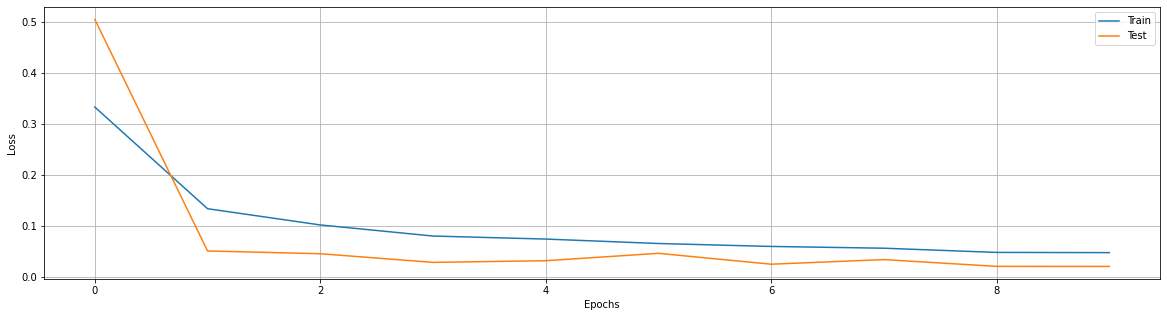

In [44]:
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train' , 'Test'])
plt.grid()
plt.show()

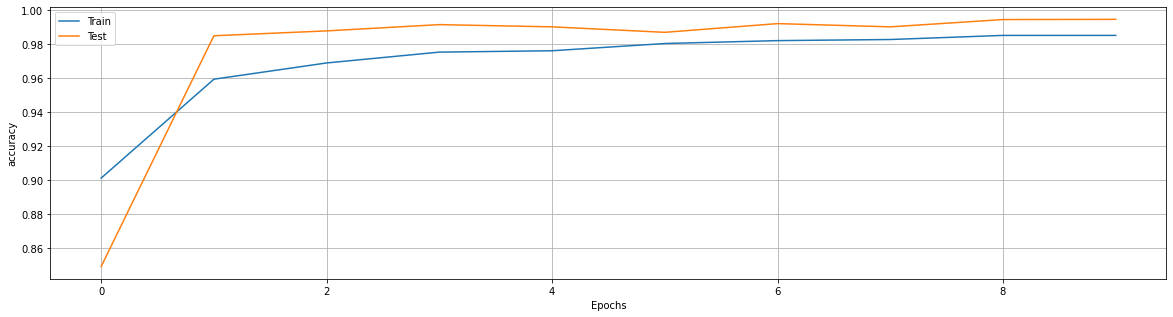

In [45]:
plt.figure(figsize=(20,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Train' , 'Test'])
plt.grid()
plt.show()

In [46]:
#Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

In [47]:
import cv2

# Generate Random Numbers
rdm = np.random.randint(0,42000,size=4)

from google.colab.patches import cv2_imshow


cv2_imshow(train_df.drop('label',axis=1).values[[100]].reshape(28,28))
cv2_imshow(train_df.drop('label',axis=1).values[[20]].reshape(28,28))


In [54]:
#score = model.score(x_test , y_test) #'Sequential' object has no attribute 'score'
#print(score)

In [65]:
#performance
pred = model.predict(x_test)

In [66]:
pred

array([[1.91634957e-13, 1.14895593e-10, 5.21415376e-11, ...,
        6.71750087e-08, 4.68736661e-10, 3.27109069e-11],
       [6.55251631e-09, 4.32879377e-09, 5.82089967e-08, ...,
        1.02917530e-09, 3.12531711e-07, 7.43504991e-09],
       [1.42849399e-09, 3.31456863e-06, 2.00593480e-08, ...,
        3.70570490e-07, 9.38375209e-08, 3.25389067e-07],
       ...,
       [4.51721860e-08, 3.00022607e-09, 1.03437635e-07, ...,
        2.24625046e-06, 2.58295756e-07, 9.99984980e-01],
       [3.35186257e-07, 3.18066706e-03, 9.96439040e-01, ...,
        1.45749727e-04, 3.34777383e-07, 4.32223644e-08],
       [1.50875419e-08, 1.15960859e-06, 8.57174018e-06, ...,
        9.99932289e-01, 7.09236581e-09, 5.46309020e-05]], dtype=float32)

In [76]:
pred1 = np.argmax(pred , axis=1)    #before calculating performance convert the values to 0 and 1 (x_test)

In [68]:
print(pred1)

[4 3 3 ... 9 2 7]


In [77]:
y_test1 = np.argmax(y_test , axis=1)    #before calculating performance convert the values to 0 and 1 (y_test)

In [71]:
print(y_test1)

[4 3 3 ... 9 2 7]


In [49]:
#accuracy_score
#confusion_matrix
#classification_report

In [50]:
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report

In [72]:
confusion_matrix(y_test1 , pred1)

array([[843,   0,   0,   1,   0,   0,   4,   0,   0,   0],
       [  0, 919,   0,   0,   1,   0,   2,   3,   0,   1],
       [  0,   1, 886,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0, 872,   0,   3,   0,   0,   3,   1],
       [  0,   0,   0,   0, 786,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   0, 739,   5,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0, 806,   0,   1,   0],
       [  0,   1,   2,   0,   0,   0,   0, 903,   0,   0],
       [  0,   0,   2,   0,   0,   1,   2,   0, 772,   1],
       [  1,   0,   0,   2,   1,   0,   0,   0,   2, 829]])

In [73]:
accuracy_score(y_test1 , pred1)

0.9946428571428572

In [75]:
print(classification_report(y_test1 , pred1))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       848
           1       1.00      0.99      1.00       926
           2       1.00      1.00      1.00       888
           3       1.00      0.99      0.99       879
           4       1.00      1.00      1.00       788
           5       0.99      0.99      0.99       745
           6       0.98      1.00      0.99       807
           7       1.00      1.00      1.00       906
           8       0.99      0.99      0.99       778
           9       0.99      0.99      0.99       835

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400

